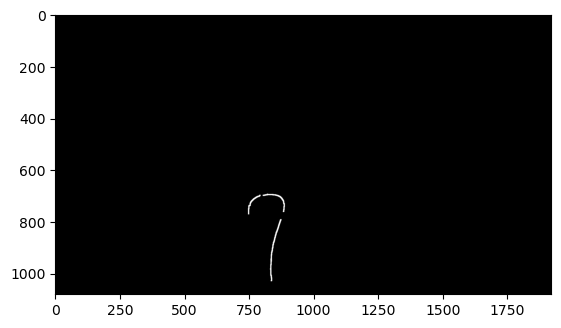

In [2]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import cv2

image_folder = 'Data/Datasets/RigidModelVideo-11-21/11-21-1-clip2/outputs_f_t_100/segmentation'

sample_image = cv2.imread(f"{image_folder}/frame0393.jpg", cv2.IMREAD_GRAYSCALE)

plt.imshow(sample_image, cmap='gray')

In [3]:
sample_image.shape

(1080, 1920)

3


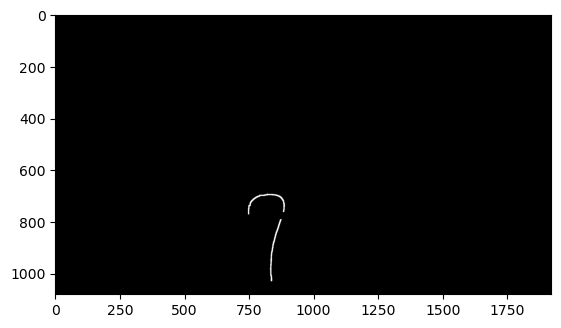

In [4]:
# stack and morphological fill using sitk:
import SimpleITK as sitk

def get_stacked_image(files: list[str])-> sitk.Image:
    images = np.stack([cv2.imread(file, cv2.IMREAD_GRAYSCALE) for file in files], axis=2)
    return images 

# naive version
def temporal_fill_process(index, ref_count = 10, ksize = 5):
    stacked_image = get_stacked_image([f"{image_folder}/frame{i:04d}.jpg" for i in range(index - ref_count, index + 1)])
    stacked_image = sitk.GetImageFromArray(stacked_image)
    print(stacked_image.GetDimension())
    filter = sitk.BinaryMorphologicalClosingImageFilter()
    filter.SetKernelType(sitk.sitkBox)
    filter.SetKernelRadius(ksize)
    filter.SetForegroundValue(255)
    filled_image = filter.Execute(stacked_image)
    return sitk.GetArrayFromImage(filled_image)[:, :, -1]

sample_filled = temporal_fill_process(393, ref_count=15)
plt.imshow(sample_filled, cmap='gray')

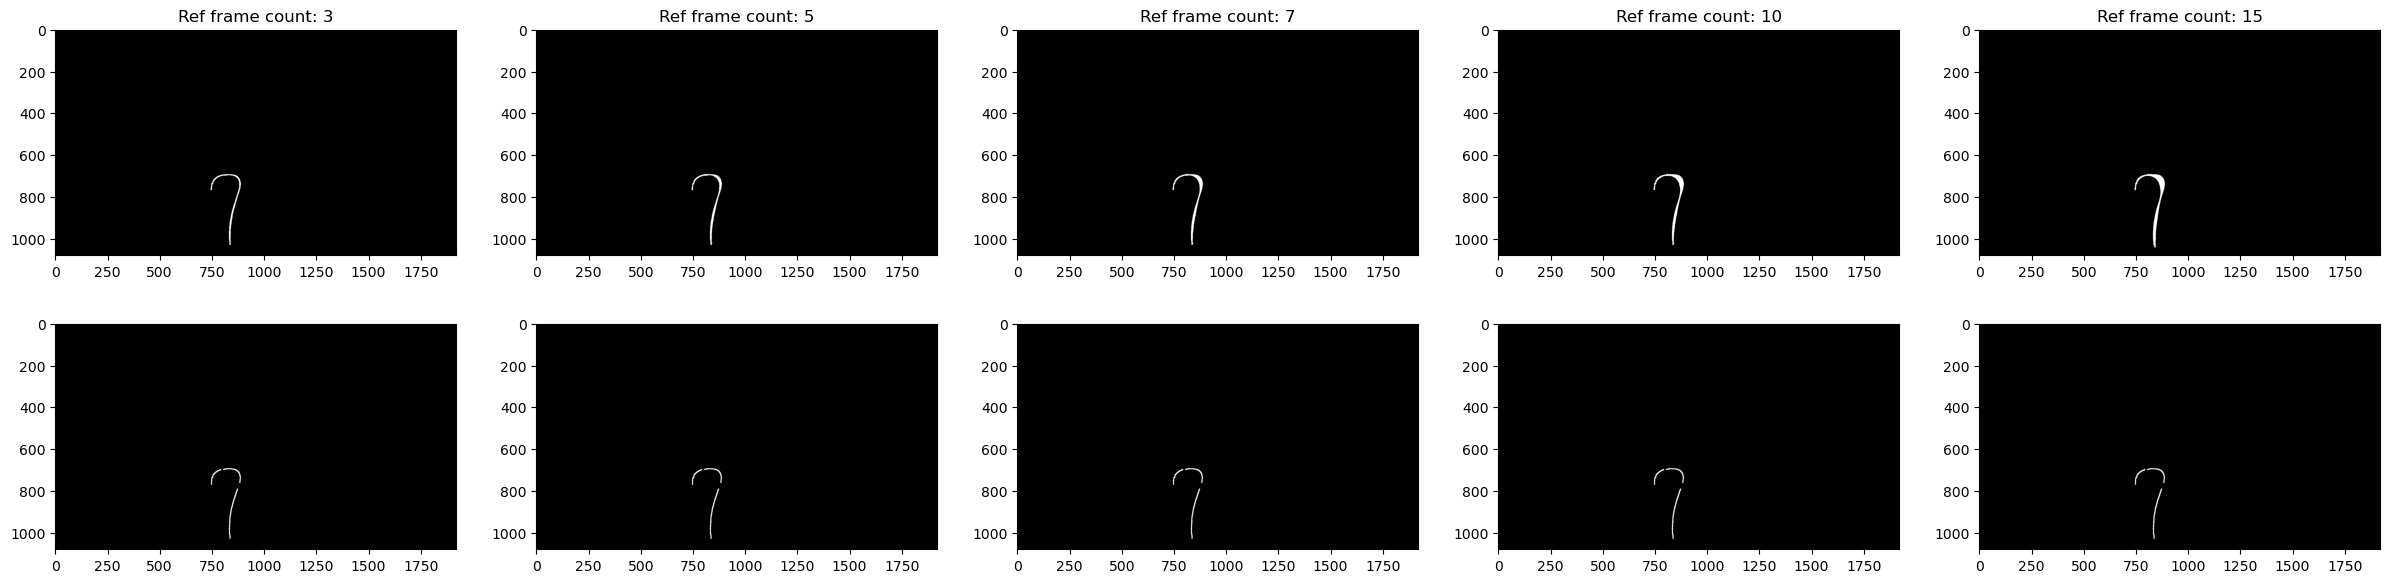

In [69]:
# Not work since only retrospective ref images and kernel size cant be too large
# Do it in custom way

def get_stacked_image_from_index(idx, ref_count):
    return get_stacked_image([f"{image_folder}/frame{i:04d}.jpg" for i in range(idx - ref_count, idx + 1)])

def get_stack_sum(idx, ref_count):
    stacked_image = get_stacked_image_from_index(idx-1, ref_count)
    return np.bitwise_or.reduce(stacked_image, axis=2)

def fill_frame_1(index, ref_count):
    ref_sum = get_stack_sum(index, ref_count)
    return np.bitwise_or(ref_sum, cv2.IMREAD_GRAYSCALE)

def test_naive_method(index):
    target_frame = cv2.imread(f"{image_folder}/frame{index:04d}.jpg", cv2.IMREAD_GRAYSCALE)
    _, axs = plt.subplots(2, 5, figsize=(30, 7))
    for i, r in enumerate([3,5,7,10,15]):
        axs[0][i].imshow(get_stack_sum(index - 1, r), cmap='gray')
        axs[0][i].set_title(f"Ref frame count: {r}")
        axs[1][i].imshow(target_frame, cmap='gray')
    plt.show()

test_naive_method(393)

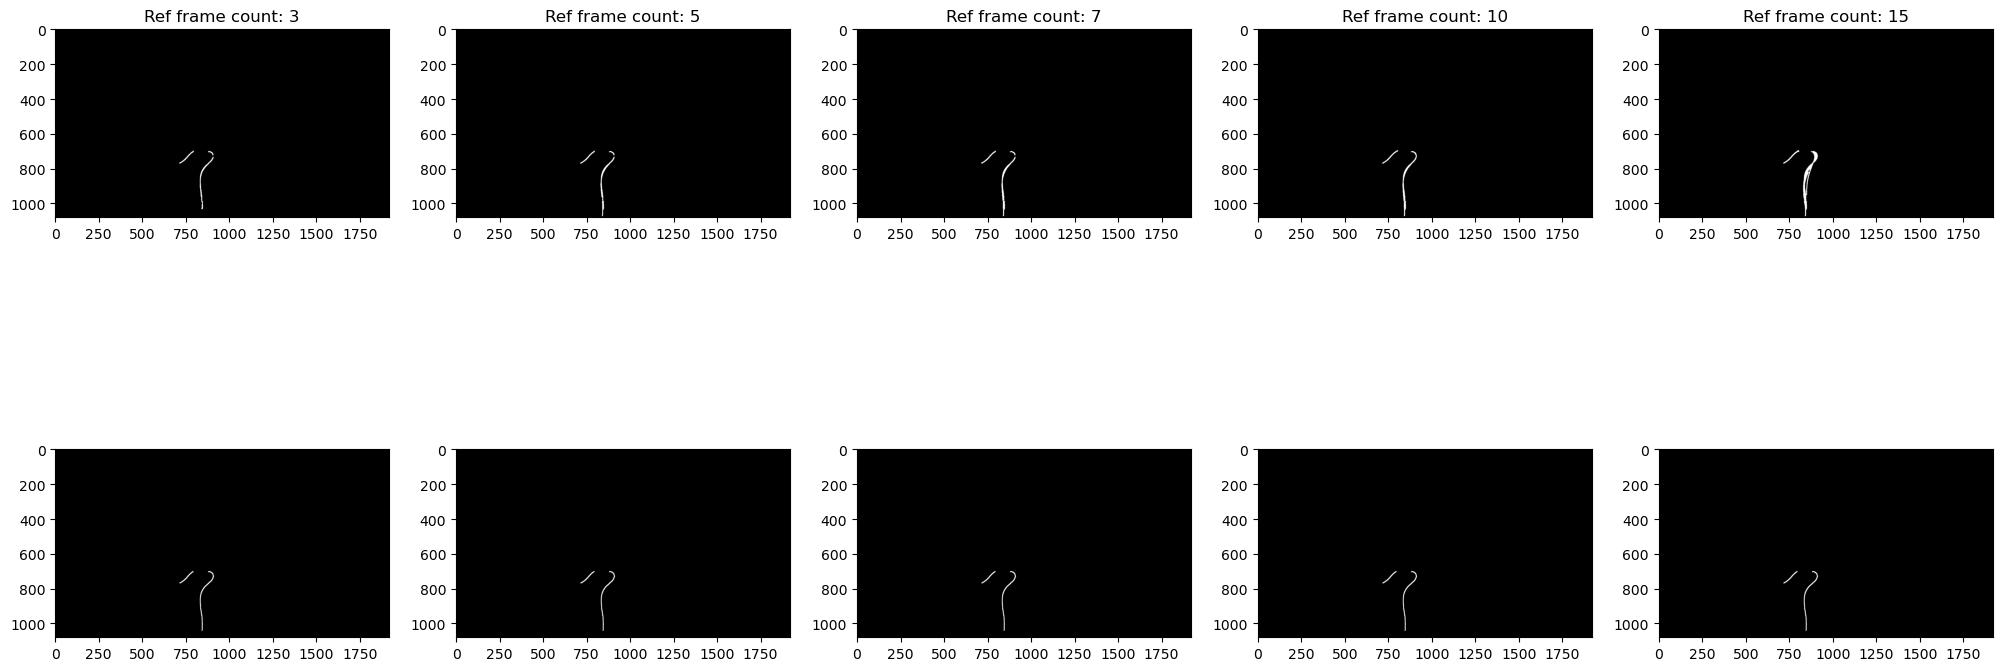

In [6]:
test_naive_method(773)

100%|██████████| 315/315 [00:11<00:00, 26.38it/s]


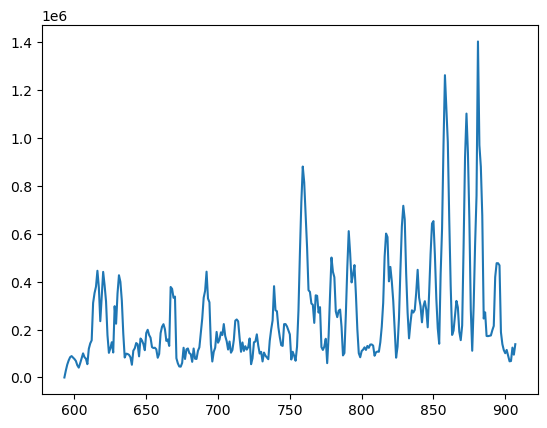

In [7]:
# See how previous correction can correct future frames
from tqdm import tqdm
import os


foi = range(593, 908)
output_folder = image_folder + '/filled_1'
if not os.path.exists(output_folder):
    os.mkdir(output_folder)

def temporal_fill_process_1(foi, ref_count=10):
    ref_stack = np.zeros((1080, 1920, ref_count), dtype=np.uint8)
    pixel_incr_history = []
    for i in tqdm(foi):
        current_frame = cv2.imread(f"{image_folder}/frame{i:04d}.jpg", cv2.IMREAD_GRAYSCALE)
        ref_stack[:, :, -1] = current_frame
        frame_result = np.bitwise_or.reduce(ref_stack, axis=2)
        # update rule:
        pixel_incr_history.append(np.sum(frame_result) - np.sum(current_frame))
        # ref_stack[:, :, -1] = frame_result
        cv2.imwrite(f"{output_folder}/frame{i:04d}.jpg", frame_result)
        ref_stack = np.roll(ref_stack, shift=-1, axis=2)
    return pixel_incr_history
            
pixel_incr_history = temporal_fill_process_1(foi, 5)
plt.plot(foi, pixel_incr_history)

In [8]:
# Add update rule to do long tracking
output_folder = image_folder + '/filled_2'
def temporal_fill_process_2(foi, ref_count=10, update_thresh = 1000):
    ref_stack = np.zeros((1080, 1920, ref_count), dtype=np.uint8)
    pixel_incr_history = []
    for i in tqdm(foi):
        current_frame = cv2.imread(f"{image_folder}/frame{i:04d}.jpg", cv2.IMREAD_GRAYSCALE)
        ref_stack[:, :, -1] = current_frame
        frame_result = np.bitwise_or.reduce(ref_stack, axis=2)
        # update rule:
        frame_diff = (np.sum(frame_result) - np.sum(current_frame)) / 255
        pixel_incr_history.append(frame_diff)
        if frame_diff > update_thresh:
            ref_stack[:, :, -1] = frame_result # current frame updated!
        cv2.imwrite(f"{output_folder}/frame{i:04d}.jpg", frame_result)
        ref_stack = np.roll(ref_stack, shift=-1, axis=2)
    return pixel_incr_history

_ = temporal_fill_process_2(foi, 5, 1000)

100%|██████████| 315/315 [00:09<00:00, 33.22it/s]


[False  True]


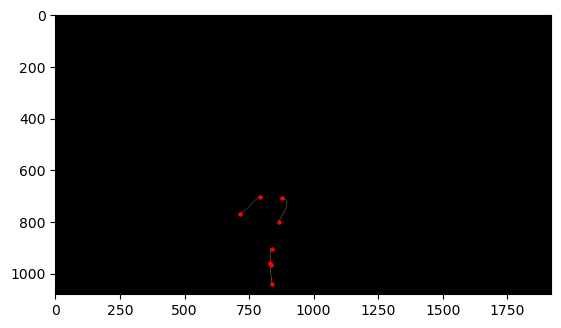

In [24]:
from skimage.morphology import skeletonize
# Version 3: Search for connections between fractured filament
def find_endpoint(binary_image):
    # kernel = np.array([[1, 1, 1], [1, 0, 1], [1, 1, 1]])
    result = find_connectivity(binary_image)
    return np.argwhere(result == 2)

def find_connectivity(binary_image):
    result = np.zeros_like(binary_image, dtype=np.uint8)
    for [i, j] in np.argwhere(binary_image):
        conn_count = 0
        for ii in range(i-1, i+2):
            for jj in range(j-1, j+2):
                if binary_image[ii, jj]:
                    conn_count += 1
        result[i, j] = conn_count
    return result

sample_image = cv2.imread(f"{image_folder}/frame0855.jpg", cv2.IMREAD_GRAYSCALE)
sample_image = sample_image > 10
skeleton = skeletonize(sample_image)
print(np.unique(sample_image))
endpoints = find_endpoint(skeleton)
plt.imshow(skeleton, cmap='gray')
plt.scatter(endpoints[:, 1], endpoints[:, 0], c='r', s=5)

In [25]:
# How can we determine search areas?
paired = []
bboxes = []
for i, ep in enumerate(endpoints):
    if i in paired:
        continue
    distances = [cv2.norm(ep, e) for e in endpoints]
    for idx in np.argsort(distances):
        if idx == i:
            continue
        candidate = endpoints[idx]
        x_min = min(ep[0], candidate[0])
        x_max = max(ep[0], candidate[0])
        y_min = min(ep[1], candidate[1])
        y_max = max(ep[1], candidate[1])
        roi = skeleton[x_min:x_max, y_min:y_max]
        if np.sum(roi) > 1:
            continue    
        else :
            print(f"Endpoint {endpoints[i]} and {endpoints[idx]} are connected")
            paired.append(i)
            paired.append(idx)
            bboxes.append([x_min, x_max, y_min, y_max])
            break    
left_most_point = endpoints[np.argmin(endpoints[:, 1])]
bottom_most_point = endpoints[np.argmax(endpoints[:, 0])]
bboxes.append([left_most_point[0] - 1, left_most_point[0] + 1, left_most_point[1] - 1, left_most_point[1]])
bboxes.append([bottom_most_point[0] - 50, skeleton.shape[0] - 11, bottom_most_point[1] - 50, bottom_most_point[1]+50])
sk_c = skeleton.copy().astype(np.uint8) * 255

for bbox in bboxes:
    cv2.rectangle(sk_c, (bbox[2]-10, bbox[0]-10), (bbox[3]+10, bbox[1]+10), 128, 1)

cv2.imwrite(image_folder + '/skeleton855.png', sk_c)
    

Endpoint [703 792] and [706 879] are connected
Endpoint [801 865] and [905 837] are connected
Endpoint [958 832] and [965 835] are connected
Endpoint [1040  837] and [905 837] are connected


True

100%|██████████| 123/123 [00:04<00:00, 26.51it/s]


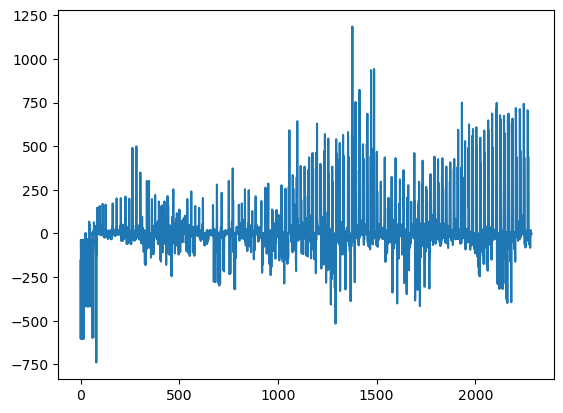

In [57]:
def find_search_area(skeleton, endpoints, connectpoint_padding=10, endpoint_padding=40):
    paired = []
    bboxes = []
    if endpoints.shape[0] == 0:
        return []
    for i, ep in enumerate(endpoints):
        if i in paired:
            continue
        distances = [cv2.norm(ep, e) for e in endpoints]
        for idx in np.argsort(distances):
            if idx == i:
                continue
            candidate = endpoints[idx]
            x_min = min(ep[0], candidate[0])
            x_max = max(ep[0], candidate[0])
            y_min = min(ep[1], candidate[1])
            y_max = max(ep[1], candidate[1])
            roi = skeleton[x_min:x_max, y_min:y_max]
            if np.sum(roi) > 1:
                continue    
            else :
                paired.append(i)
                paired.append(idx)
                bboxes.append([
                    x_min - connectpoint_padding, 
                    x_max + connectpoint_padding, 
                    y_min - connectpoint_padding, 
                    y_max + connectpoint_padding
                ])
                break
    left_most_point = endpoints[np.argmin(endpoints[:, 1])]
    bottom_most_point = endpoints[np.argmax(endpoints[:, 0])]
    bboxes.append([
        left_most_point[0] - endpoint_padding, 
        left_most_point[0] + endpoint_padding, 
        left_most_point[1] - endpoint_padding, 
        left_most_point[1]
    ])
    bboxes.append([
        bottom_most_point[0] - endpoint_padding,
        skeleton.shape[0] - 1, 
        bottom_most_point[1] - endpoint_padding, 
        bottom_most_point[1] + endpoint_padding
    ])
    return bboxes
    
output_folder = image_folder + '/filled_3'
if not os.path.exists(output_folder):
    os.mkdir(output_folder)

def temporal_fill_process_3(foi, ref_count=5, search_area_padding = 10, endpoint_area_padding=40, update_thresh = 100):
    d = []
    ref_stack = np.zeros((1080, 1920, ref_count), dtype=np.uint8)
    for i in tqdm(foi):
        current_frame = cv2.imread(f"{image_folder}/frame{i:04d}.jpg", cv2.IMREAD_GRAYSCALE)
        skeleton = skeletonize(current_frame > 40) # get clean segmentation if using jpeg
        endpoints = find_endpoint(skeleton)
        search_areas = find_search_area(skeleton, endpoints, search_area_padding, endpoint_area_padding)
        for r in range(ref_count):
            ref_frame = ref_stack[:, :, -r]
            for bbox in search_areas:
                if len(bbox) == 0:
                    continue
                roi_ref = ref_frame[bbox[0]:bbox[1], bbox[2]:bbox[3]]
                roi_cur = current_frame[bbox[0]:bbox[1], bbox[2]:bbox[3]]
                
                diff = (np.sum(roi_ref, dtype=int) - np.sum(roi_cur)) / 255.0
                d.append(diff)
                if np.sum(diff) > update_thresh: # have find something, append it
                    search_result = np.bitwise_or.reduce((roi_ref, roi_cur))
                    current_frame[bbox[0]:bbox[1], bbox[2]:bbox[3]] = search_result
                    # print(f"Frame {i} updated at bbox {bbox}")
                    # clear bbox:
                    bbox = []
        ref_stack = np.roll(ref_stack, shift=-1, axis=2)
        ref_stack[:, :, -1] = current_frame
        cv2.imwrite(f"{output_folder}/frame{i:04d}.jpg", ref_frame)
    plt.plot(d)
        
temporal_fill_process_3(range(632, 755), 5, 10, 20)   

# 658, 697, 733     

100%|██████████| 123/123 [00:04<00:00, 26.58it/s]


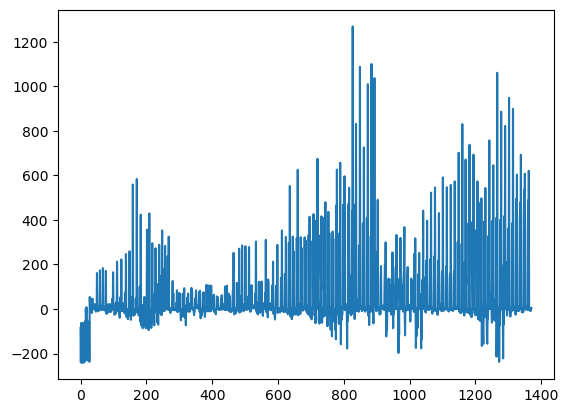

In [51]:
output_folder = image_folder + '/filled_4'
if not os.path.exists(output_folder):
    os.mkdir(output_folder)

temporal_fill_process_3(range(632, 755), 3, 5, 20)   

100%|██████████| 315/315 [00:12<00:00, 25.85it/s]


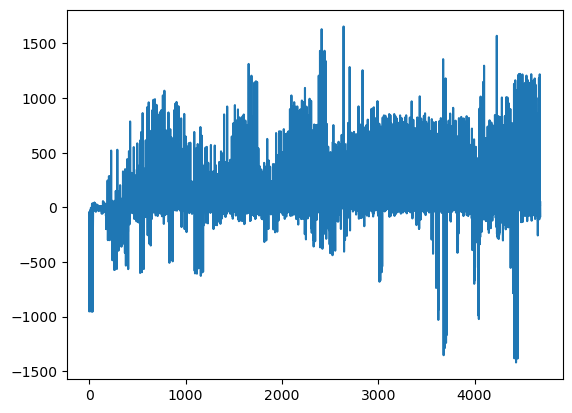

In [58]:
output_folder = image_folder + '/filled_5'
if not os.path.exists(output_folder):
    os.mkdir(output_folder)

temporal_fill_process_3(foi, 4, 7, endpoint_area_padding=30, update_thresh=100)   

100%|██████████| 315/315 [00:12<00:00, 26.16it/s]


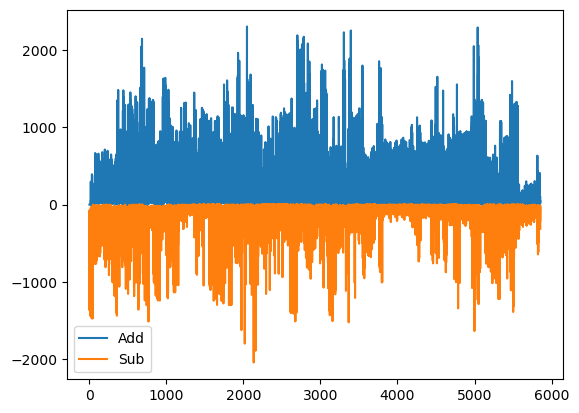

In [65]:
# identify misalignment vs missing parts
def temporal_fill_process_4(foi, ref_count=5, search_area_padding = 10, endpoint_area_padding=40, update_thresh = 100):
    d = []
    ref_stack = np.zeros((1080, 1920, ref_count), dtype=np.uint8)
    for i in tqdm(foi):
        current_frame = cv2.imread(f"{image_folder}/frame{i:04d}.jpg", cv2.IMREAD_GRAYSCALE)
        skeleton = skeletonize(current_frame > 40) # get clean segmentation if using jpeg
        endpoints = find_endpoint(skeleton)
        search_areas = find_search_area(skeleton, endpoints, search_area_padding, endpoint_area_padding)
        for r in range(ref_count):
            ref_frame = ref_stack[:, :, -r]
            for bbox in search_areas:
                if len(bbox) == 0:
                    continue
                roi_ref = ref_frame[bbox[0]:bbox[1], bbox[2]:bbox[3]]
                roi_cur = current_frame[bbox[0]:bbox[1], bbox[2]:bbox[3]]
                roi_diff = roi_ref.astype(int) - roi_cur
                
                diff_add = np.count_nonzero(roi_diff > 0)
                diff_sub = np.count_nonzero(roi_diff < 0)
                d.append([diff_add, -diff_sub])
                if (diff_add - diff_sub) > update_thresh and diff_sub < 500 and diff_add < 1000: # have find something, append it
                    search_result = np.bitwise_or.reduce((roi_ref, roi_cur))
                    current_frame[bbox[0]:bbox[1], bbox[2]:bbox[3]] = search_result
                    # print(f"Frame {i} updated at bbox {bbox}")
                    # clear bbox:
                    bbox = []
        ref_stack = np.roll(ref_stack, shift=-1, axis=2)
        ref_stack[:, :, -1] = current_frame
        cv2.imwrite(f"{output_folder}/frame{i:04d}.jpg", ref_frame)
    d = np.array(d)
    plt.plot(d[:, 0], label='Add')
    plt.plot(d[:, 1], label='Sub')
    plt.legend()
    

output_folder = image_folder + '/filled_6'
if not os.path.exists(output_folder):
    os.mkdir(output_folder)    
temporal_fill_process_4(foi, 5, 10, endpoint_area_padding=50, update_thresh=100)